## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

In [4]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

# Download the Data

In [6]:
url= "brain_stroke_in_numeric_without_useless_data.csv"
brain = pd.read_csv(url)
brain = brain.drop(brain.columns[0], axis=1)

## A Quick Look at the Data Structure

In [7]:
brain.head(100) 

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,228.69,36.6,2,1
1,0,80.0,0,1,1,105.92,32.5,1,1
2,1,49.0,0,0,1,171.23,34.4,3,1
3,1,79.0,1,0,1,174.12,24.0,1,1
4,0,81.0,0,0,1,186.21,29.0,2,1
...,...,...,...,...,...,...,...,...,...
95,0,71.0,1,1,0,216.94,30.9,1,1
96,0,61.0,1,0,1,76.11,27.3,3,1
97,0,74.0,0,0,1,72.96,31.3,3,1
98,1,38.0,0,0,0,82.28,24.0,2,1


Each row represents one district.

In [8]:
#This method prints information about a DataFrame including the dtype and columns, non-null values and memory usage.
brain.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   int64  
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   int64  
 5   avg_glucose_level  4981 non-null   float64
 6   bmi                4981 non-null   float64
 7   smoking_status     4981 non-null   int64  
 8   stroke             4981 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 350.4 KB


In [9]:
#This method shows a statistical summary of the numerical attributes 
brain.describe()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,0.583618,43.419859,0.096165,0.055210,0.658502,105.943562,28.498173,1.184501,0.049789
std,0.493008,22.662755,0.294848,0.228412,0.474260,45.075373,6.790464,1.031769,0.217531
min,0.000000,0.080000,0.000000,0.000000,0.000000,55.120000,14.000000,0.000000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,77.230000,23.700000,0.000000,0.000000
50%,1.000000,45.000000,0.000000,0.000000,1.000000,91.850000,28.100000,1.000000,0.000000
75%,1.000000,61.000000,0.000000,0.000000,1.000000,113.860000,32.600000,2.000000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,271.740000,48.900000,3.000000,1.000000


# Prepare the Data for Machine Learning Algorithms

In [10]:
#Provides train/test indices to split data in train/test sets.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [11]:
for train_index, test_index in split.split(brain, brain["stroke"]):
    strat_train_set = brain.loc[train_index]
    strat_test_set = brain.loc[test_index]

In [12]:
brain = strat_train_set.drop("stroke", axis=1)
brain_labels = strat_train_set["stroke"].copy()

## Transformation Pipelines

For our case we apply the minmaxScaler to keep the value into a positive range 


In [13]:
from sklearn.model_selection import train_test_split
X = brain.iloc[:,0:8]

X_train, X_test, y_train, y_test = train_test_split(X, brain_labels, test_size=0.3, random_state=42)

## Naive Bayes

- linear Regression
- Multinomial Naive Bayes
- Gaussian Naive Bayes
- Complement Naive Bayes
- Bernoulli Naive Bayes
- Categorical Naive Bayes


In [14]:
### Multinomial Naive Bayes

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score 


multinomialNB = MultinomialNB(alpha=1.0, class_prior=[0.4, 0.6])
y_pred = multinomialNB.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6379598662207357


In [16]:
y_train_pred = cross_val_predict(multinomialNB, X_train, y_train, cv=3)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print("TN: %.0f" % tn + ", FP: %.0f" % fp + ", FN: %.0f" % fn + ", TP: %.0f" % tp)

TN: 1671, FP: 969, FN: 33, TP: 115


In [17]:
# TP / TP + FP
tp / (tp + fp)

0.10608856088560886

In [18]:
precision_score(y_train, y_train_pred)

0.10608856088560886

In [19]:
# TP / TP + FN
tp / (tp + fn)

0.777027027027027

In [20]:
recall_score(y_train, y_train_pred)

0.777027027027027

In [21]:
# TP / TP + FN
sensitivity = tp / (tp + fn)
print(sensitivity)

0.777027027027027


In [22]:
# TN / TN + FP
specificity = tn / (tn + fp) 
print(specificity)

0.6329545454545454


In [23]:
# tpr = sensitivity
# fpr = 1 - specificity
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# calculate AUC
auc = roc_auc_score(y_train, y_train_pred)
print(auc)

0.7049907862407863


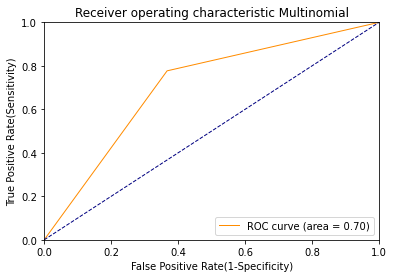

In [24]:
plt.figure()
lw = 1
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate(1-Specificity)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic Multinomial")
plt.legend(loc="lower right")
plt.show()

In [25]:
### Gaussian Naive Bayes

In [26]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8595317725752508


In [27]:
y_train_pred = cross_val_predict(gnb, X_train, y_train, cv=3)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print("TN: %.0f" % tn + ", FP: %.0f" % fp + ", FN: %.0f" % fn + ", TP: %.0f" % tp)

TN: 2329, FP: 311, FN: 82, TP: 66


In [28]:
# TP / TP + FP
tp / (tp + fp)

0.17506631299734748

In [29]:
precision_score(y_train, y_train_pred)

0.17506631299734748

In [30]:
# TP / TP + FN
tp / (tp + fn)

0.44594594594594594

In [31]:
recall_score(y_train, y_train_pred)

0.44594594594594594

In [32]:
# TP / TP + FN
sensitivity = tp / (tp + fn)
print(sensitivity)

0.44594594594594594


In [33]:
# TN / TN + FP
specificity = tn / (tn + fp) 
print(specificity)

0.8821969696969697


In [34]:
# tpr = sensitivity
# fpr = 1 - specificity
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# calculate AUC
auc = roc_auc_score(y_train, y_train_pred)
print(auc)

0.6640714578214579


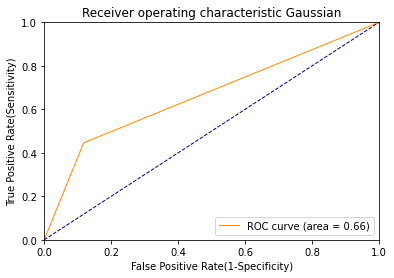

In [35]:
plt.figure()
lw = 1
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate(1-Specificity)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic Gaussian")
plt.legend(loc="lower right")
plt.show()

In [36]:
### Complement Naive Bayes

In [37]:
from sklearn.naive_bayes import ComplementNB

complement = ComplementNB()
y_pred = complement.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6663879598662207


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_train_pred = cross_val_predict(complement, X_train, y_train, cv=3)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print("TN: %.0f" % tn + ", FP: %.0f" % fp + ", FN: %.0f" % fn + ", TP: %.0f" % tp)
# cm = confusion_matrix(y_train, y_train_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

TN: 1746, FP: 894, FN: 37, TP: 111


In [39]:
# TP / TP + FP
tp / (tp + fp)

0.11044776119402985

In [40]:
precision_score(y_train, y_train_pred)

0.11044776119402985

In [41]:
# TP / TP + FN
tp / (tp + fn)

0.75

In [42]:
recall_score(y_train, y_train_pred)

0.75

In [43]:
# TP / TP + FN
sensitivity = tp / (tp + fn)
print(sensitivity)

0.75


In [44]:
# TN / TN + FP
specificity = tn / (tn + fp) 
print(specificity)

0.6613636363636364


In [45]:
# tpr = sensitivity
# fpr = 1 - specificity
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# calculate AUC
auc = roc_auc_score(y_train, y_train_pred)
print(auc)

0.7056818181818182


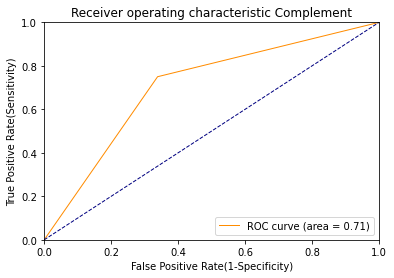

In [46]:
plt.figure()
lw = 1
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate(1-Specificity)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic Complement")
plt.legend(loc="lower right")
plt.show()

In [47]:
### Bernoulli Naive Bayes

In [48]:
from sklearn.naive_bayes import BernoulliNB

bernoulli = BernoulliNB()
y_pred = bernoulli.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9448160535117057


In [49]:
y_train_pred = cross_val_predict(bernoulli, X_train, y_train, cv=3)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print("TN: %.0f" % tn + ", FP: %.0f" % fp + ", FN: %.0f" % fn + ", TP: %.0f" % tp)

TN: 2631, FP: 9, FN: 144, TP: 4


In [50]:
# TP / TP + FP
tp / (tp + fp)

0.3076923076923077

In [51]:
precision_score(y_train, y_train_pred, zero_division=0)

0.3076923076923077

In [52]:
# TP / TP + FN
tp / (tp + fn)

0.02702702702702703

In [53]:
recall_score(y_train, y_train_pred)

0.02702702702702703

In [54]:
# TP / TP + FN
sensitivity = tp / (tp + fn)
print(sensitivity)

0.02702702702702703


In [55]:
# TN / TN + FP
specificity = tn / (tn + fp) 
print(specificity)

0.9965909090909091


In [56]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# calculate AUC
auc = roc_auc_score(y_train, y_train_pred)
print(auc)

0.511808968058968


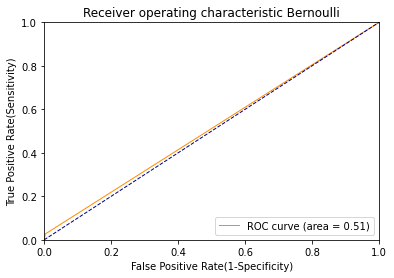

In [57]:
plt.figure()
lw = 1
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate(1-Specificity)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic Bernoulli")
plt.legend(loc="lower right")
plt.show()

In [58]:
### Categorical Naive Bayes

In [59]:
from sklearn.naive_bayes import CategoricalNB

categorical = CategoricalNB()
y_pred = categorical.fit(X_train, y_train).predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9381270903010034


In [60]:
y_train_pred = cross_val_predict(categorical, X_train, y_train, cv=3)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
print("TN: %.0f" % tn + ", FP: %.0f" % fp + ", FN: %.0f" % fn + ", TP: %.0f" % tp)

TN: 2576, FP: 64, FN: 134, TP: 14


In [61]:
# TP / TP + FP
tp / (tp + fp)

0.1794871794871795

In [62]:
precision_score(y_train, y_train_pred)

0.1794871794871795

In [63]:
# TP / TP + FN
tp / (tp + fn)

0.0945945945945946

In [64]:
recall_score(y_train, y_train_pred)

0.0945945945945946

In [65]:
# TP / TP + FN
sensitivity = tp / (tp + fn)
print(sensitivity)

0.0945945945945946


In [66]:
# TN / TN + FP
specificity = tn / (tn + fp) 
print(specificity) 

0.9757575757575757


In [67]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
# calculate AUC
auc = roc_auc_score(y_train, y_train_pred)
print(auc)

0.5351760851760851


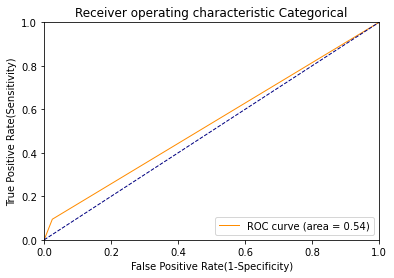

In [68]:
plt.figure()
lw = 1
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate(1-Specificity)")
plt.ylabel("True Positive Rate(Sensitivity)")
plt.title("Receiver operating characteristic Categorical")
plt.legend(loc="lower right")
plt.show()